In [1]:
from __future__ import division
from functools import partial
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from numpy.linalg import inv,pinv
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
matplotlib.style.use('ggplot')

from performance import *
from tqdm import tqdm

In [2]:
# # Generate graphs of returns
# def plot_perf2(perf, label, title, benchmark_label = 'Market-RF'):
#     fig, ax = plt.subplots(nrows=1, figsize=(12,6))
#     if type(perf) is not list:
#         perf = [perf]
#         label = [label]
#     for i in range(len(perf)):
#         ax.plot(perf[i], linewidth=1, label=label[i])
#     ax.set_ylabel('Cumulative Returns')
#     ax.set_title(title)
#     ax.legend(loc='best')

# Purpose of the Notebook

**Part 1: Sharpe Ratio Parity**
1. Create Sharpe Ratio parity weightings
2. Generate SR parity for 4 factors (BAB) and 3 factors + market.

**Part 2: Distance Weighted SR Portfolio**
1. Generate SR parity for 4 factors (BAB) and 3 factors + market - distance weight these
2. Equal weight

In [3]:
country_etfs = pd.read_csv('../Data/country_data/ETF_adj_close.csv',index_col=0)
country_etfs.index = pd.to_datetime(country_etfs.index)
ff5 = pdr.famafrench.FamaFrenchReader('Emerging_5_Factors',start = '2000-01-01').read()[0]
ff_mom = pdr.famafrench.FamaFrenchReader('Emerging_MOM_Factor',start = '2000-01-01').read()[0]
ff6 = pd.concat([ff5,ff_mom],axis=1)

In [4]:
# find weekly return - take last date and pct-change
country_returns = country_etfs.resample('W').last().pct_change()
# country_returns.index = country_returns.index.to_period('W')

In [5]:
equity_factors = pd.read_pickle('../Outputs/equity/equity_country_factors_rf.pkl')

equity_factors = equity_factors[equity_factors.momentum.notnull()]

In [6]:
market_ret_w = pd.read_pickle('../Outputs/equity/equity_EM_agg_market_returns.pkl')
market_ret_w = market_ret_w[(market_ret_w.index>='2017-09-24') & (market_ret_w.index<='2020-12-27')]
market_ret_w = market_ret_w[['EEM ETF']]
market_ret_w['EEM ETF_cum_ret'] = np.exp(market_ret_w['EEM ETF'].cumsum())-1

# Part I: Sharpe Ratio Parity
## 1. Create SR parity weightings


In [7]:
sigma_p=0.05

In [8]:
def calc_SR(s, n = 52):
    return s.mean()/s.std() * (n**0.5)

def calc_lambda(SR, sigma = sigma_p):
    top_ = np.sqrt((SR**2).sum(axis=1))
    lambda_ = top_/2/sigma
    return lambda_

def calc_weight(SR, lambda_t,sigma):
    temp = SR.dropna()
    rc = temp.divide(lambda_t.loc[temp.index],axis=0)/2
    w = rc/sigma
    
    return rc, w

## 2. Create SR portfolios for 4 factors (BAB) and 3 factors + market

Rolling Window = 52 weeks

In [9]:
# Create SR portfolios
def create_sr_port(equity_factors, factors_selected, time = 52):
    sigma_nt = equity_factors[factors_selected].rolling(time).std()
    SR_t = equity_factors[factors_selected].rolling(time).apply(calc_SR)
    lambda_t = calc_lambda(SR_t)
    rc, w = calc_weight(SR_t, lambda_t, sigma_nt)
    w = w.divide(w.abs().sum(axis=1),axis=0) # Use gross w
    #sr_return = np.sum(np.multiply(w.dropna(),equity_factors.loc[w.dropna().index][factors_selected]),axis=1)
    sr_return = np.sum(np.multiply(w.dropna(),equity_factors.shift(1).loc[w.dropna().index][factors_selected]),axis=1)
    return sr_return, SR_t, w

In [10]:
# Create 4 factor portfolio (BAB): Size, Value, Momentum, Low Beta
factors4 = ['size', 'value', 'momentum', 'low_beta']
sr_return_4factors, factors4_SR_t, factors4_w = create_sr_port(equity_factors, factors4)

In [11]:
# Create 3 factor portfolio + 100% market: Size, Value, Momentum and Market
factors3 = ['size', 'value', 'momentum']
sr_return_3factors, factors3_SR_t, factors3_w = create_sr_port(equity_factors, factors3)
sr_return_3factors_mkt = (sr_return_3factors + equity_factors['market-rf']).dropna()

In [12]:
sr_portfolios = pd.concat([sr_return_4factors, sr_return_3factors_mkt], axis=1)
sr_portfolios.columns = ['4 factors', '3 factors + mkt']
sr_portfolios['3 factors + mkt cumulative returns'] = np.cumprod(1 + sr_portfolios['3 factors + mkt']) - 1
sr_portfolios['4 factors cumulative returns'] = np.cumprod(1 + sr_portfolios['4 factors']) - 1

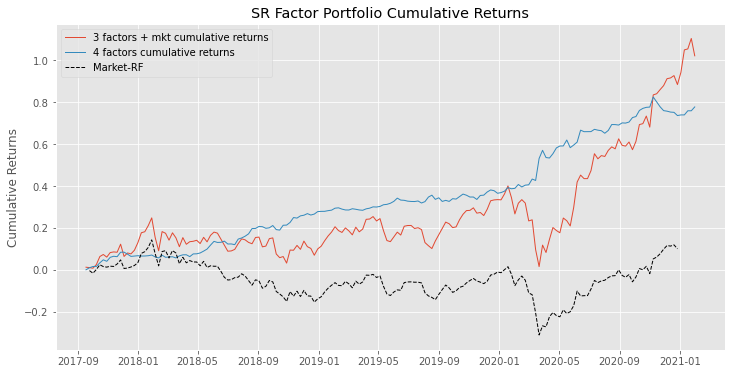

In [13]:
plot_perf(perf=[sr_portfolios[x] for x in list(sr_portfolios.columns.values)[-2:]], perf_bm=market_ret_w['EEM ETF_cum_ret'],\
         label = [x for x in list(sr_portfolios.columns.values)[-2:]], \
         title='SR Factor Portfolio Cumulative Returns')

# Part II: Macro weighted approach

In [14]:
gdp_dist = pd.read_pickle('../Outputs/macroeconomics/gdp_distance.pickle')
vol_dist = pd.read_pickle('../Outputs/macroeconomics/vol_distance.pickle')

gdp_dist = gdp_dist.loc['2017-09-17':]
vol_dist = vol_dist.loc['2017-09-17':]

In [15]:
def calc_distance_weight(SR_t, gdp_dist, vol_dist):
    dist_weight, didx = [], []
    macro_w = np.matrix([2/3,1/3])
    for d in range(len(SR_t)):
        try:
            date = SR_t.index[d]
            drng = SR_t.index[0:d]

            w_gdp = gdp_dist[date]
            normed_w_gdp = w_gdp.divide(w_gdp.sum())
            new_w_gdp = normed_w_gdp.dropna().values @ SR_t.loc[drng].dropna().values
            #new_w_gdp = w_gdp.dropna().values @ SR_t.loc[drng].dropna().values

            w_vol = vol_dist[date]
            normed_w_vol = w_vol.divide(w_vol.sum())
            new_w_vol = normed_w_vol.dropna().values @ SR_t.loc[drng].dropna().values
            #new_w_vol = w_vol.dropna().values @ SR_t.loc[drng].dropna().values

            didx.append(date)
            dist_weight.append(macro_w @ np.c_[new_w_gdp,new_w_vol].T)
        except:
            print(d)
    
    # Generate dataframe of distance weighted SR's
    dist_SR_w = pd.DataFrame(np.array(dist_weight).squeeze(),index = didx, columns = list(SR_t))
    
    return dist_SR_w

def calc_sr_port_weighted(SR_t, factors_selected, time = 52):
    sigma_nt = equity_factors[factors_selected].rolling(time).std()
    lambda_t = calc_lambda(SR_t)
    rc, w = calc_weight(SR_t, lambda_t, sigma_nt)
    w = w.divide(w.abs().sum(axis=1),axis=0) # Use gross w
    #sr_return = np.sum(np.multiply(w.dropna(),equity_factors.loc[w.dropna().index][factors_selected]),axis=1)
    sr_return = np.sum(np.multiply(w.dropna(),equity_factors.shift(1).loc[w.dropna().index][factors_selected]),axis=1)
    return sr_return

In [16]:
# Create 4 factor portfolio (BAB): Size, Value, Momentum, Low Beta
factors4 = ['size', 'value', 'momentum', 'low_beta']
SR_factors4_w = calc_distance_weight(factors4_SR_t.dropna(), gdp_dist, vol_dist)
SR_factors4_weighted_ret = calc_sr_port_weighted(SR_factors4_w, factors4)

172
173
174
175
176


In [17]:
# Create 3 factor portfolio + 100% market: Size, Value, Momentum and Market
factors3 = ['size', 'value', 'momentum']
SR_factors3_w = calc_distance_weight(factors3_SR_t.dropna(), gdp_dist, vol_dist)
SR_factors3_weighted_ret = calc_sr_port_weighted(SR_factors3_w, factors3)
SR_factors3_weighted_ret_mkt = (SR_factors3_weighted_ret + equity_factors['market-rf']).dropna()

172
173
174
175
176


In [18]:
sr_portfolios_w = pd.concat([SR_factors4_weighted_ret, SR_factors3_weighted_ret_mkt], axis=1)
sr_portfolios_w.columns = ['4 factors', '3 factors + mkt']
sr_portfolios_w['3 factors + mkt cumulative returns'] = np.cumprod(1 + sr_portfolios_w['3 factors + mkt']) - 1
sr_portfolios_w['4 factors cumulative returns'] = np.cumprod(1 + sr_portfolios_w['4 factors']) - 1

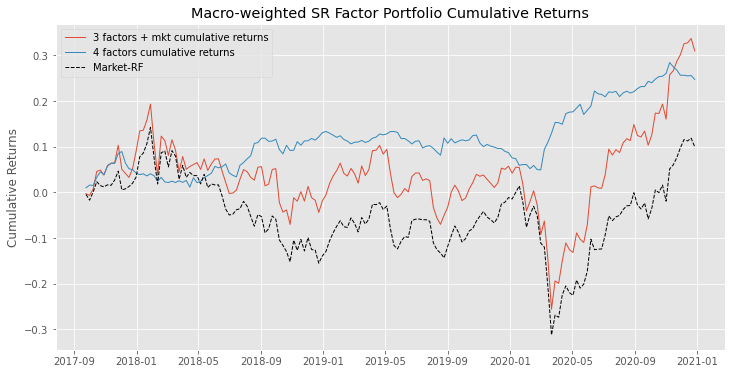

In [19]:
plot_perf(perf=[sr_portfolios_w[x] for x in list(sr_portfolios_w.columns.values)[-2:]], perf_bm=market_ret_w['EEM ETF_cum_ret'], \
         label = [x for x in list(sr_portfolios_w.columns.values)[-2:]], \
         title='Macro-weighted SR Factor Portfolio Cumulative Returns')

# Plots

In [20]:
# Cumulative returns
sr_port_cum_ret = sr_portfolios[['3 factors + mkt cumulative returns', '4 factors cumulative returns']]
sr_port_cum_ret.columns = ['3 factors + mkt', '4 factors (BAB)']
dist_cum_ret = sr_portfolios_w[['3 factors + mkt cumulative returns', '4 factors cumulative returns']]
dist_cum_ret.columns = ['3 factors + mkt (macro weighted)', '4 factors BAB (macro weighted)']
all_cum_ret = pd.concat([sr_port_cum_ret, dist_cum_ret], axis=1)
all_cum_ret.dropna(inplace=True)

# Regular returns
dist_ret = sr_portfolios_w[['3 factors + mkt', '4 factors']]
sr_port_ret = sr_portfolios[['3 factors + mkt', '4 factors']]
all_ret = pd.concat([sr_port_ret, dist_ret], axis=1)
all_ret.columns = ['3 factors + mkt', '4 factors (BAB)', '3 factors + mkt (macro weighted)', '4 factors BAB (macro weighted)']
all_ret.dropna(inplace=True)

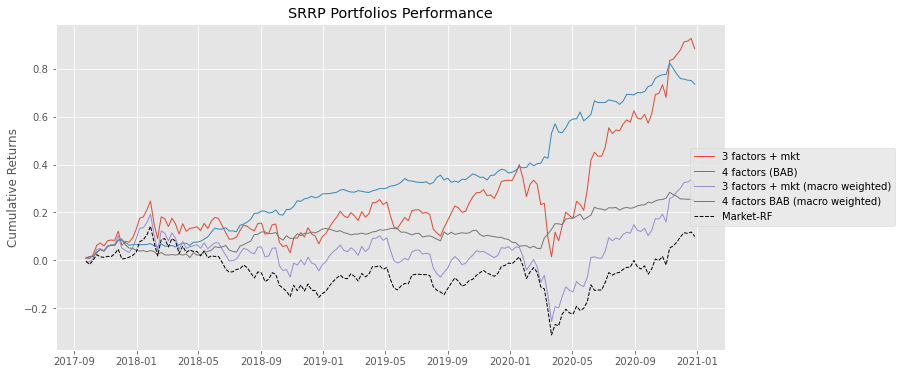

In [21]:
plot_perf(perf=[all_cum_ret[x] for x in list(all_cum_ret.columns.values)], perf_bm=market_ret_w['EEM ETF_cum_ret'], \
         label = [x for x in list(all_cum_ret.columns.values)], \
         title='SRRP Portfolios Performance')
plt.legend(bbox_to_anchor=[1.1, 0.5], loc='center');

In [22]:
all_perf = []
for col in all_ret.columns:
    perf_ = calc_performance(all_ret[col], log_ret=False, mkt=market_ret_w['EEM ETF'])
    all_perf.append(perf_)

perf_df = pd.DataFrame(all_perf, columns = ['Mean Return Ann. (%)', 'Std Ann. (%)', 'Sharpe Ratio Ann.', 'Skewness', 'Kurtosis', 'Max Drawdown (%)', 'Max Drawdown Date', 'Market Beta', 'Market Correlation'], \
                       index = ['3 factors + mkt', '4 factors (BAB)', '3 factors + mkt (macro weighted)', '4 factors BAB (macro weighted)'])
perf_df

,Mean Return Ann. (%),Std Ann. (%),Sharpe Ratio Ann.,Skewness,Kurtosis,Max Drawdown (%),Max Drawdown Date,Market Beta,Market Correlation
3 factors + mkt,20.82,22.31,0.93,-0.28,2.11,27.53,2020-03-22,0.964,0.92
4 factors (BAB),18.29,7.58,2.41,1.78,10.23,4.86,2020-12-27,-0.044,-0.126
3 factors + mkt (macro weighted),8.54,21.9,0.39,-0.59,2.87,37.61,2020-03-22,0.987,0.953
4 factors BAB (macro weighted),6.95,6.91,1.01,0.85,2.47,7.41,2020-03-01,-0.02,-0.061
